<a href="https://colab.research.google.com/github/GangaMegha/Generative-Models/blob/main/DeepBeliefNetwork_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import matplotlib.pyplot as plt

# Import MNIST data
import tensorflow as tf


## RBM Class

In [2]:
class RBM():
    def __init__(self, num_hidden, num_visible, lr, n, batch_size, epochs):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.lr = lr
        self.n = n
        self.batch_size = batch_size
        self.epochs = epochs

        self.W = np.random.randn(num_hidden, num_visible)/np.sqrt(0.5*(num_visible + num_hidden)) # weights

        self.b_h = np.zeros((num_hidden, 1)) # bias latent
        self.b_v = np.zeros((num_visible, 1)) # bias visible

        self.dW = []
        self.db_h = []
        self.db_v = []

    def sigmoid(self, x):  
        #Sigmoid activation 
        #Implemented interms  of tanh for increased stability
        return .5 * (1 + np.tanh(.5 * x))

    
    def bernoulli_array(self, prob_array, dim):
        # Simulating Bernoulli from uniform
        sample = np.zeros(dim)

        # Draw x~Uni[0,1]
        uni_sample = np.random.uniform(0, 1, dim)

        # return 1 if x < p else return 0
        diff = uni_sample - prob_array
        coords = np.argwhere(diff<0)
        sample[[*coords.T]] = 1  

        return sample

    def gibbs_sampling(self, h_0):

        h = h_0.copy()

        for i in range(self.n):

            # (v x h) @ (h x b) + (v x 1) = (v x b)
            p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
            v = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))

            # (h x v) @ (v x b) + (h x 1) = (h x b)
            p_h_v = self.sigmoid(self.W @ v + self.b_h)
            h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        return v, h, p_h_v

    def hidden_to_visible(self, h):

        h = h.T.copy()

        # (v x h) @ (h x b) + (v x 1) = (v x b)
        p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
        v = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))

        return v.T

    def visible_to_hidden(self, v):

        v = v.T.copy()

        # (h x v) @ (v x b) + (h x 1) = (h x b)
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        return h.T

    def gradient_descent(self, v_0, p_h_v_0, v_n, p_h_v_n):

        # Compute the gradients
        # (h x b) @ (b x v) - (h x b) @ (b x v) = (h x v)
        self.dW = (p_h_v_0 @ v_0 - p_h_v_n @ v_n)/self.batch_size
        self.db_h = np.mean(p_h_v_0 - p_h_v_n, axis=1)[:, np.newaxis]
        self.db_v = np.mean(v_0 - v_n, axis=0)[:, np.newaxis]
        
        # Weight update
        self.W   = self.W   + self.lr * self.dW
        self.b_h = self.b_h + self.lr * self.db_h
        self.b_v = self.b_v + self.lr * self.db_v


    def reconstruction_error(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return np.sum(np.mean((v-v_sampled)**2, axis=1), axis=0)


    def reconstruct_image(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return v_sampled


    def Train(self, train, val):

        num_batches = int(train.shape[0]/self.batch_size)
        train_loss = []
        val_loss = []

        for epoch in range(self.epochs):

            # Shuffling the data
            train = np.random.permutation(train)

            # Splitting data into batches
            batches = np.array_split(train, num_batches)

            for i in range(num_batches):

                # visible units from data
                v_0 = batches[i].T

                # (h x v) @ (v x b) + (h x 1) = (h x b)
                p_h_v_0 = self.sigmoid(self.W @ v_0 + self.b_h)
                h_0 = self.bernoulli_array(p_h_v_0, (p_h_v_0.shape[0], p_h_v_0.shape[1]))

                # Run the markov chain
                v_n, h_n, p_h_v_n = self.gibbs_sampling(h_0)

                # Compute gradients
                self.gradient_descent(v_0.T, p_h_v_0, v_n.T, p_h_v_n)

            # Compute reconstruction errror
            error_train = self.reconstruction_error(train.T)
            error_val = self.reconstruction_error(val.T)

            print(f"Epoch {epoch+1} ------> Error => Train : {error_train}, Val : {error_val}")
 
            train_loss.append(error_train)
            val_loss.append(error_val)

        return train_loss, val_loss



# Fashion MNIST Data

4423680/4422102 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


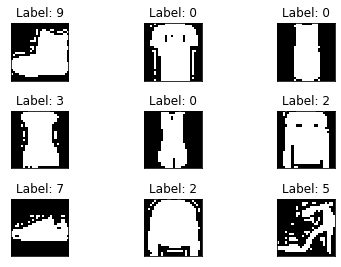

In [3]:
# Load MNIST data
fashion_mnist = tf.keras.datasets.fashion_mnist
(train, train_y), (test, test_y) = fashion_mnist.load_data()

train = train.copy()
train_y = train_y.copy()

test = test.copy()
test_y = test_y.copy()

# Converting to binary
train[[*np.argwhere(train>0).T]] = 1
test[[*np.argwhere(test>0).T]] = 1


fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(train[i], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(train_y[i]))
  plt.xticks([])
  plt.yticks([])

In [4]:
# Split data into Train, Val, Test and flatten the images
frac = 0.15

n = int(frac*(train.shape[0]))
val = train[:n]
train = train[n:]

train = train.reshape(train.shape[0], -1)
val = val.reshape(val.shape[0], -1)
test = test.reshape(test.shape[0], -1)

print('Train: ', train.shape)
print('Val: ', val.shape)
print('Test:  ', test.shape)

print("\n\nUnique labels : ", np.unique(train_y))

Train:  (51000, 784)
Val:  (9000, 784)
Test:   (10000, 784)


Unique labels :  [0 1 2 3 4 5 6 7 8 9]


# Train and Inference

In [6]:
# RBM config
num_hidden = 256 # number of hidden units
lr = 0.001 # learning rate for gradient descent
n = 1 # number of Gibbs sampling steps
batch_size = 100 # mini batch size for gradient update
epochs = 300 # number of epochs

In [7]:
rbm_1 = RBM(num_hidden, val.shape[1], lr, n, batch_size, epochs)
train_loss, val_loss = rbm_1.Train(train, val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1 ------> Error => Train : 206.11180392156865, Val : 205.67211111111112
Epoch 2 ------> Error => Train : 178.73403921568627, Val : 178.3458888888889
Epoch 3 ------> Error => Train : 164.97245098039215, Val : 164.30866666666668
Epoch 4 ------> Error => Train : 156.00231372549018, Val : 155.25022222222222
Epoch 5 ------> Error => Train : 149.96113725490196, Val : 149.22622222222222
Epoch 6 ------> Error => Train : 145.26072549019608, Val : 144.54733333333334
Epoch 7 ------> Error => Train : 141.50225490196078, Val : 140.68466666666666
Epoch 8 ------> Error => Train : 138.19286274509804, Val : 137.61955555555556
Epoch 9 ------> Error => Train : 135.35427450980393, Val : 134.92988888888888
Epoch 10 ------> Error => Train : 132.62474509803923, Val : 132.03988888888887
Epoch 11 ------> Error => Train : 130.53119607843138, Val : 129.95222222222222
Epoch 12 ------> Error => Train : 128.29445098039216, Val : 127.85522222222221
Epoch 13 ------> Error => Train : 126.5922156862745, Val : 126

Text(0, 0.5, 'Error')

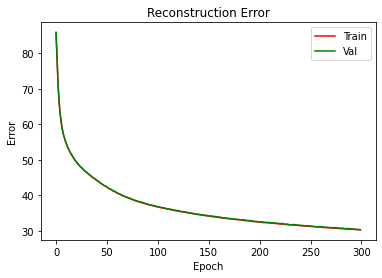

In [31]:
fig = plt.figure()
plt.plot(train_loss, c='r', label="Train")
plt.plot(val_loss, c='g', label="Val")
plt.legend()
plt.title("Reconstruction Error")
plt.xlabel("Epoch")
plt.ylabel("Error")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
path = F"/content/gdrive/My Drive/rbm_1.pkl" 
pickle.dump([rbm_1.W, rbm_1.b_v, rbm_1.b_h], open(path, "wb"))

# Test data and Image Reconstruction



Original Images ....


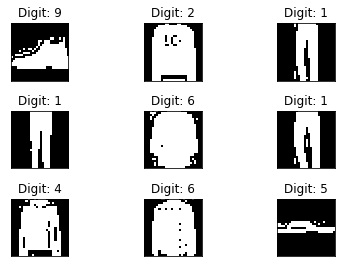

In [9]:
print("\n\nOriginal Images ....")
fig1 = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(test[i].reshape((28,28)), cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(test_y[i]))
  plt.xticks([])
  plt.yticks([])



Sampled images....


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


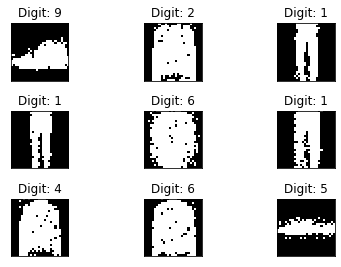

In [11]:
print("\n\nSampled images....")
fig2 = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()

  # 1 step sampling
  img = rbm_1.reconstruct_image(test[i].T.reshape((784,1)))

  plt.imshow(img.reshape((28,28)), cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(test_y[i]))
  plt.xticks([])
  plt.yticks([])

# Train 2nd RBM to improve the prior

In [27]:
class RBM_prior():
    def __init__(self, num_hidden, num_visible, lr, n, batch_size, epochs, W_old, b_v_old, b_h_old):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.lr = lr
        self.n = n
        self.batch_size = batch_size
        self.epochs = epochs
        self.W_old = W_old
        self.b_v_old = b_v_old
        self.b_h_old = b_h_old

        self.W = np.random.randn(num_hidden, num_visible)/np.sqrt(0.5*(num_visible + num_hidden)) # weights

        self.b_h = np.zeros((num_hidden, 1)) # bias latent
        self.b_v = np.zeros((num_visible, 1)) # bias visible

        self.dW = []
        self.db_h = []
        self.db_v = []

    def sigmoid(self, x):  
        #Sigmoid activation 
        #Implemented interms  of tanh for increased stability
        return .5 * (1 + np.tanh(.5 * x))

    
    def bernoulli_array(self, prob_array, dim):
        # Simulating Bernoulli from uniform
        sample = np.zeros(dim)

        # Draw x~Uni[0,1]
        uni_sample = np.random.uniform(0, 1, dim)

        # return 1 if x < p else return 0
        diff = uni_sample - prob_array
        coords = np.argwhere(diff<0)
        sample[[*coords.T]] = 1  

        return sample

    def gibbs_sampling(self, h_0):

        h = h_0.copy()

        for i in range(self.n):

            # (v x h) @ (h x b) + (v x 1) = (v x b)
            p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
            v = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))

            # (h x v) @ (v x b) + (h x 1) = (h x b)
            p_h_v = self.sigmoid(self.W @ v + self.b_h)
            h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        return v, h, p_h_v

    def hidden_to_visible(self, h):

        h = h.T.copy()

        # (v x h) @ (h x b) + (v x 1) = (v x b)
        p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
        v = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))

        return v.T

    def visible_to_hidden(self, v):

        v = v.T.copy()

        # (h x v) @ (v x b) + (h x 1) = (h x b)
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        return h.T

    def gradient_descent(self, v_0, p_h_v_0, v_n, p_h_v_n):

        # Compute the gradients
        # (h x b) @ (b x v) - (h x b) @ (b x v) = (h x v)
        self.dW = (p_h_v_0 @ v_0 - p_h_v_n @ v_n)/self.batch_size
        self.db_h = np.mean(p_h_v_0 - p_h_v_n, axis=1)[:, np.newaxis]
        self.db_v = np.mean(v_0 - v_n, axis=0)[:, np.newaxis]
        
        # Weight update
        self.W   = self.W   + self.lr * self.dW
        self.b_h = self.b_h + self.lr * self.db_h
        self.b_v = self.b_v + self.lr * self.db_v


    def reconstruction_error(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return np.sum(np.mean((v-v_sampled)**2, axis=1), axis=0)


    def reconstruct_image(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return v_sampled


    def Train(self, train, val):

        num_batches = int(train.shape[0]/self.batch_size)
        train_loss = []
        val_loss = []

        for epoch in range(self.epochs):

            # Shuffling the data
            train = np.random.permutation(train)

            # Splitting data into batches
            batches = np.array_split(train, num_batches)

            for i in range(num_batches):

                # ---- From first RBM -----
                # visible units from data
                v_0 = batches[i].T

                # (h x v) @ (v x b) + (h x 1) = (h x b)
                p_h_v_0 = self.sigmoid(self.W_old @ v_0 + self.b_h_old)
                h_0 = self.bernoulli_array(p_h_v_0, (p_h_v_0.shape[0], p_h_v_0.shape[1]))

                # ---- For prior RBM -----

                # (l x h) @ (h x b) + (l x 1) = (l x b)
                p_l_h_0 = self.sigmoid(self.W @ h_0 + self.b_h)
                l_0 = self.bernoulli_array(p_l_h_0, (p_l_h_0.shape[0], p_l_h_0.shape[1]))

                # Run the markov chain
                h_n, l_n, p_l_h_n = self.gibbs_sampling(l_0)

                # Compute gradients
                self.gradient_descent(h_0.T, p_l_h_0, h_n.T, p_l_h_n)

            # Compute reconstruction errror
            v_0 = train.T
            p_h_v_0 = self.sigmoid(self.W_old @ v_0 + self.b_h_old)
            h_0 = self.bernoulli_array(p_h_v_0, (p_h_v_0.shape[0], p_h_v_0.shape[1]))
            error_train = self.reconstruction_error(h_0)

            v_0 = val.T
            p_h_v_0 = self.sigmoid(self.W_old @ v_0 + self.b_h_old)
            h_0 = self.bernoulli_array(p_h_v_0, (p_h_v_0.shape[0], p_h_v_0.shape[1]))
            error_val = self.reconstruction_error(h_0)

            print(f"Epoch {epoch+1} ------> Error => Train : {error_train}, Val : {error_val}")
 
            train_loss.append(error_train)
            val_loss.append(error_val)

        return train_loss, val_loss



In [23]:
# RBM config
num_hidden = 64 # number of hidden units
num_visible = 256 # number of hidden units
lr = 0.001 # learning rate for gradient descent
n = 1 # number of Gibbs sampling steps
batch_size = 100 # mini batch size for gradient update
epochs = 300 # number of epochs

In [28]:
rbm_2 = RBM_prior(num_hidden, num_visible, lr, n, batch_size, epochs, rbm_1.W, rbm_1.b_v, rbm_1.b_h)
train_loss, val_loss = rbm_2.Train(train, val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1 ------> Error => Train : 85.66933333333333, Val : 85.92922222222222
Epoch 2 ------> Error => Train : 78.24162745098039, Val : 78.45
Epoch 3 ------> Error => Train : 71.18613725490195, Val : 71.10533333333333
Epoch 4 ------> Error => Train : 66.22749019607843, Val : 66.29711111111112
Epoch 5 ------> Error => Train : 62.97919607843137, Val : 63.10011111111112
Epoch 6 ------> Error => Train : 60.63778431372549, Val : 60.760222222222225
Epoch 7 ------> Error => Train : 58.86390196078432, Val : 58.885777777777776
Epoch 8 ------> Error => Train : 57.402686274509804, Val : 57.36944444444444
Epoch 9 ------> Error => Train : 56.349215686274505, Val : 56.38733333333333
Epoch 10 ------> Error => Train : 55.35413725490196, Val : 55.42644444444444
Epoch 11 ------> Error => Train : 54.57341176470588, Val : 54.71366666666667
Epoch 12 ------> Error => Train : 53.817921568627455, Val : 53.86944444444444
Epoch 13 ------> Error => Train : 53.18082352941177, Val : 53.1891111111111
Epoch 14 ------>

Text(0, 0.5, 'Error')

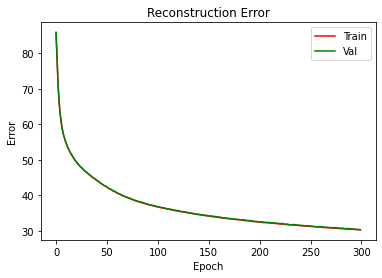

In [32]:
fig = plt.figure()
plt.plot(train_loss, c='r', label="Train")
plt.plot(val_loss, c='g', label="Val")
plt.legend()
plt.title("Reconstruction Error")
plt.xlabel("Epoch")
plt.ylabel("Error")

# Train new RBM using the prior

In [52]:
class RBM_new():
    def __init__(self, num_hidden, num_visible, lr, n, batch_size, epochs, W_prior, b_v_prior, b_h_prior):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.lr = lr
        self.n = n
        self.batch_size = batch_size
        self.epochs = epochs
        self.W_prior = W_prior
        self.b_v_prior = b_v_prior
        self.b_h_prior = b_h_prior

        self.W = np.random.randn(num_hidden, num_visible)/np.sqrt(0.5*(num_visible + num_hidden)) # weights

        self.b_h = np.zeros((num_hidden, 1)) # bias latent
        self.b_v = np.zeros((num_visible, 1)) # bias visible

        self.dW = []
        self.db_h = []
        self.db_v = []

    def sigmoid(self, x):  
        #Sigmoid activation 
        #Implemented interms  of tanh for increased stability
        return .5 * (1 + np.tanh(.5 * x))

    
    def bernoulli_array(self, prob_array, dim):
        # Simulating Bernoulli from uniform
        sample = np.zeros(dim)

        # Draw x~Uni[0,1]
        uni_sample = np.random.uniform(0, 1, dim)

        # return 1 if x < p else return 0
        diff = uni_sample - prob_array
        coords = np.argwhere(diff<0)
        sample[[*coords.T]] = 1  

        return sample

    def gibbs_sampling(self, h_0):

        h = h_0.copy()

        for i in range(self.n):

            # (v x h) @ (h x b) + (v x 1) = (v x b)
            p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
            v = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))

            # (h x v) @ (v x b) + (h x 1) = (h x b)
            p_h_v = self.sigmoid(self.W @ v + self.b_h)
            h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        return v, h, p_h_v

    def hidden_to_visible(self, h):

        h = h.T.copy()

        # (v x h) @ (h x b) + (v x 1) = (v x b)
        p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
        v = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))

        return v.T

    def visible_to_hidden(self, v):

        v = v.T.copy()

        # (h x v) @ (v x b) + (h x 1) = (h x b)
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        return h.T

    def gradient_descent(self, v_0, p_h_v_0, v_n, p_h_v_n):

        # Compute the gradients
        # (h x b) @ (b x v) - (h x b) @ (b x v) = (h x v)
        self.dW = (p_h_v_0 @ v_0 - p_h_v_n @ v_n)/self.batch_size
        self.db_h = np.mean(p_h_v_0 - p_h_v_n, axis=1)[:, np.newaxis]
        self.db_v = np.mean(v_0 - v_n, axis=0)[:, np.newaxis]
        
        # Weight update
        self.W   = self.W   + self.lr * self.dW
        self.b_h = self.b_h + self.lr * self.db_h
        self.b_v = self.b_v + self.lr * self.db_v


    def reconstruction_error(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # For prior RBM
        p_l_h = self.sigmoid(self.W_prior @ h + self.b_h_prior)
        l = self.bernoulli_array(p_l_h, (p_l_h.shape[0], p_l_h.shape[1]))

        p_h_l = self.sigmoid(self.W_prior.T @ l + self.b_v_prior)
        h_cap = self.bernoulli_array(p_h_l, (p_h_l.shape[0], p_h_l.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h_cap + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return np.sum(np.mean((v-v_sampled)**2, axis=1), axis=0)


    def reconstruct_image(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # For prior RBM
        p_l_h = self.sigmoid(self.W_prior @ h + self.b_h_prior)
        l = self.bernoulli_array(p_l_h, (p_l_h.shape[0], p_l_h.shape[1]))

        p_h_l = self.sigmoid(self.W_prior.T @ l + self.b_v_prior)
        h_cap = self.bernoulli_array(p_h_l, (p_h_l.shape[0], p_h_l.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h_cap + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return v_sampled


    def Train(self, train, val):

        num_batches = int(train.shape[0]/self.batch_size)
        train_loss = []
        val_loss = []

        for epoch in range(self.epochs):

            # Shuffling the data
            train = np.random.permutation(train)

            # Splitting data into batches
            batches = np.array_split(train, num_batches)

            for i in range(num_batches):

                # visible units from data
                v_0 = batches[i].T

                # (h x v) @ (v x b) + (h x 1) = (h x b)
                p_h_v_0 = self.sigmoid(self.W @ v_0 + self.b_h)
                h_0 = self.bernoulli_array(p_h_v_0, (p_h_v_0.shape[0], p_h_v_0.shape[1]))

                # For prior RBM
                p_l_h_0 = self.sigmoid(self.W_prior @ h_0 + self.b_h_prior)
                l_0 = self.bernoulli_array(p_l_h_0, (p_l_h_0.shape[0], p_l_h_0.shape[1]))

                p_h_l_0 = self.sigmoid(self.W_prior.T @ l_0 + self.b_v_prior)
                h_0_cap = self.bernoulli_array(p_h_l_0, (p_h_l_0.shape[0], p_h_l_0.shape[1]))

                # Run the markov chain
                v_n, h_n, p_h_v_n = self.gibbs_sampling(h_0_cap)

                # Compute gradients
                self.gradient_descent(v_0.T, p_h_v_0, v_n.T, p_h_v_n)

            # Compute reconstruction errror
            error_train = self.reconstruction_error(train.T)
            error_val = self.reconstruction_error(val.T)

            print(f"Epoch {epoch+1} ------> Error => Train : {error_train}, Val : {error_val}")
 
            train_loss.append(error_train)
            val_loss.append(error_val)

        return train_loss, val_loss

In [53]:
# RBM config
num_hidden = 256 # number of hidden units
lr = 0.001 # learning rate for gradient descent
n = 1 # number of Gibbs sampling steps
batch_size = 100 # mini batch size for gradient update
epochs = 300 # number of epochs

In [54]:
rbm_3 = RBM_new(num_hidden, val.shape[1], lr, n, batch_size, epochs, rbm_2.W, rbm_2.b_v, rbm_2.b_h)
train_loss, val_loss = rbm_3.Train(train, val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1 ------> Error => Train : 257.2061960784314, Val : 257.2705555555556
Epoch 2 ------> Error => Train : 250.7115882352941, Val : 250.72222222222223
Epoch 3 ------> Error => Train : 244.75584313725489, Val : 244.60577777777777
Epoch 4 ------> Error => Train : 238.8976274509804, Val : 238.66133333333335
Epoch 5 ------> Error => Train : 235.13611764705882, Val : 235.02766666666668
Epoch 6 ------> Error => Train : 231.06750980392155, Val : 231.26144444444444
Epoch 7 ------> Error => Train : 228.8303137254902, Val : 229.56566666666663
Epoch 8 ------> Error => Train : 226.37898039215685, Val : 225.88100000000003
Epoch 9 ------> Error => Train : 224.33611764705884, Val : 223.47433333333333
Epoch 10 ------> Error => Train : 221.37058823529412, Val : 221.64322222222222
Epoch 11 ------> Error => Train : 220.29009803921568, Val : 220.07033333333334
Epoch 12 ------> Error => Train : 219.86203921568625, Val : 220.78522222222222
Epoch 13 ------> Error => Train : 218.63096078431371, Val : 217.12

Text(0, 0.5, 'Error')

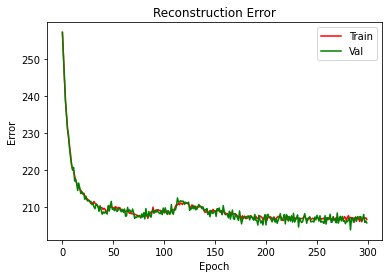

In [55]:
fig = plt.figure()
plt.plot(train_loss, c='r', label="Train")
plt.plot(val_loss, c='g', label="Val")
plt.legend()
plt.title("Reconstruction Error")
plt.xlabel("Epoch")
plt.ylabel("Error")

# Compare reconstructed images



Sampled images 1....


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


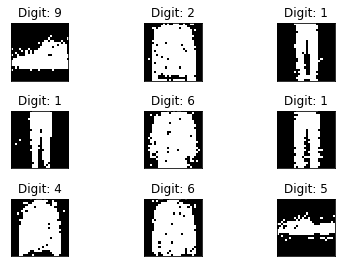

In [56]:
print("\n\nSampled images 1....")
fig2 = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()

  # 1 step sampling
  img = rbm_1.reconstruct_image(test[i].T.reshape((784,1)))

  plt.imshow(img.reshape((28,28)), cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(test_y[i]))
  plt.xticks([])
  plt.yticks([])



Sampled images 2....


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


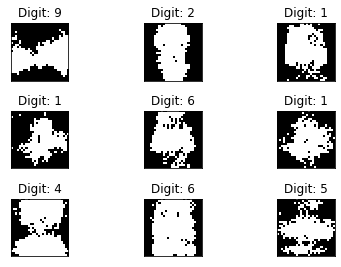

In [57]:
print("\n\nSampled images 2....")
fig2 = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()

  # 1 step sampling
  img = rbm_3.reconstruct_image(test[i].T.reshape((784,1)))

  plt.imshow(img.reshape((28,28)), cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(test_y[i]))
  plt.xticks([])
  plt.yticks([])

# Reconstruction error

In [59]:
err_1 = rbm_1.reconstruction_error(test.T)
err_3 = rbm_3.reconstruction_error(test.T)

print("Reconstruction error using original RBM : ", err_1)
print("Reconstruction error using modified RBM : ", err_3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Reconstruction error using original RBM :  73.9257
Reconstruction error using modified RBM :  207.06529999999998


# Re-Train old RBM with prior

In [60]:
class RBM_ret():
    def __init__(self, num_hidden, num_visible, lr, n, batch_size, epochs, W_prior, b_v_prior, b_h_prior, W_old, b_v_old, b_h_old):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.lr = lr
        self.n = n
        self.batch_size = batch_size
        self.epochs = epochs
        self.W_prior = W_prior
        self.b_v_prior = b_v_prior
        self.b_h_prior = b_h_prior

        self.W = W_old # weights

        self.b_h = b_h_old # bias latent
        self.b_v = b_v_old # bias visible

        self.dW = []
        self.db_h = []
        self.db_v = []

    def sigmoid(self, x):  
        #Sigmoid activation 
        #Implemented interms  of tanh for increased stability
        return .5 * (1 + np.tanh(.5 * x))

    
    def bernoulli_array(self, prob_array, dim):
        # Simulating Bernoulli from uniform
        sample = np.zeros(dim)

        # Draw x~Uni[0,1]
        uni_sample = np.random.uniform(0, 1, dim)

        # return 1 if x < p else return 0
        diff = uni_sample - prob_array
        coords = np.argwhere(diff<0)
        sample[[*coords.T]] = 1  

        return sample

    def gibbs_sampling(self, h_0):

        h = h_0.copy()

        for i in range(self.n):

            # (v x h) @ (h x b) + (v x 1) = (v x b)
            p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
            v = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))

            # (h x v) @ (v x b) + (h x 1) = (h x b)
            p_h_v = self.sigmoid(self.W @ v + self.b_h)
            h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        return v, h, p_h_v

    def hidden_to_visible(self, h):

        h = h.T.copy()

        # (v x h) @ (h x b) + (v x 1) = (v x b)
        p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
        v = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))

        return v.T

    def visible_to_hidden(self, v):

        v = v.T.copy()

        # (h x v) @ (v x b) + (h x 1) = (h x b)
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        return h.T

    def gradient_descent(self, v_0, p_h_v_0, v_n, p_h_v_n):

        # Compute the gradients
        # (h x b) @ (b x v) - (h x b) @ (b x v) = (h x v)
        self.dW = (p_h_v_0 @ v_0 - p_h_v_n @ v_n)/self.batch_size
        self.db_h = np.mean(p_h_v_0 - p_h_v_n, axis=1)[:, np.newaxis]
        self.db_v = np.mean(v_0 - v_n, axis=0)[:, np.newaxis]
        
        # Weight update
        self.W   = self.W   + self.lr * self.dW
        self.b_h = self.b_h + self.lr * self.db_h
        self.b_v = self.b_v + self.lr * self.db_v


    def reconstruction_error(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # For prior RBM
        p_l_h = self.sigmoid(self.W_prior @ h + self.b_h_prior)
        l = self.bernoulli_array(p_l_h, (p_l_h.shape[0], p_l_h.shape[1]))

        p_h_l = self.sigmoid(self.W_prior.T @ l + self.b_v_prior)
        h_cap = self.bernoulli_array(p_h_l, (p_h_l.shape[0], p_h_l.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h_cap + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return np.sum(np.mean((v-v_sampled)**2, axis=1), axis=0)


    def reconstruct_image(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # For prior RBM
        p_l_h = self.sigmoid(self.W_prior @ h + self.b_h_prior)
        l = self.bernoulli_array(p_l_h, (p_l_h.shape[0], p_l_h.shape[1]))

        p_h_l = self.sigmoid(self.W_prior.T @ l + self.b_v_prior)
        h_cap = self.bernoulli_array(p_h_l, (p_h_l.shape[0], p_h_l.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h_cap + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return v_sampled


    def Train(self, train, val):

        num_batches = int(train.shape[0]/self.batch_size)
        train_loss = []
        val_loss = []

        for epoch in range(self.epochs):

            # Shuffling the data
            train = np.random.permutation(train)

            # Splitting data into batches
            batches = np.array_split(train, num_batches)

            for i in range(num_batches):

                # visible units from data
                v_0 = batches[i].T

                # (h x v) @ (v x b) + (h x 1) = (h x b)
                p_h_v_0 = self.sigmoid(self.W @ v_0 + self.b_h)
                h_0 = self.bernoulli_array(p_h_v_0, (p_h_v_0.shape[0], p_h_v_0.shape[1]))

                # For prior RBM
                p_l_h_0 = self.sigmoid(self.W_prior @ h_0 + self.b_h_prior)
                l_0 = self.bernoulli_array(p_l_h_0, (p_l_h_0.shape[0], p_l_h_0.shape[1]))

                p_h_l_0 = self.sigmoid(self.W_prior.T @ l_0 + self.b_v_prior)
                h_0_cap = self.bernoulli_array(p_h_l_0, (p_h_l_0.shape[0], p_h_l_0.shape[1]))

                # Run the markov chain
                v_n, h_n, p_h_v_n = self.gibbs_sampling(h_0_cap)

                # Compute gradients
                self.gradient_descent(v_0.T, p_h_v_0, v_n.T, p_h_v_n)

            # Compute reconstruction errror
            error_train = self.reconstruction_error(train.T)
            error_val = self.reconstruction_error(val.T)

            print(f"Epoch {epoch+1} ------> Error => Train : {error_train}, Val : {error_val}")
 
            train_loss.append(error_train)
            val_loss.append(error_val)

        return train_loss, val_loss

In [61]:
# RBM config
num_hidden = 256 # number of hidden units
lr = 0.001 # learning rate for gradient descent
n = 1 # number of Gibbs sampling steps
batch_size = 100 # mini batch size for gradient update
epochs = 300 # number of epochs

In [62]:
rbm_4 = RBM_ret(num_hidden, val.shape[1], lr, n, batch_size, epochs, rbm_2.W, rbm_2.b_v, rbm_2.b_h, rbm_1.W, rbm_1.b_v, rbm_1.b_h)
train_loss, val_loss = rbm_4.Train(train, val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1 ------> Error => Train : 96.52523529411765, Val : 96.30199999999999
Epoch 2 ------> Error => Train : 96.98264705882353, Val : 96.72277777777778
Epoch 3 ------> Error => Train : 97.20229411764706, Val : 97.13677777777778
Epoch 4 ------> Error => Train : 97.39856862745097, Val : 97.14500000000001
Epoch 5 ------> Error => Train : 97.34294117647059, Val : 97.16055555555556
Epoch 6 ------> Error => Train : 97.47003921568628, Val : 97.05288888888889
Epoch 7 ------> Error => Train : 97.48356862745098, Val : 97.28800000000001
Epoch 8 ------> Error => Train : 97.62427450980394, Val : 97.41366666666667
Epoch 9 ------> Error => Train : 97.54786274509804, Val : 97.29533333333333
Epoch 10 ------> Error => Train : 97.38482352941176, Val : 97.31977777777777
Epoch 11 ------> Error => Train : 97.43280392156862, Val : 97.2731111111111
Epoch 12 ------> Error => Train : 97.46198039215686, Val : 97.12177777777777
Epoch 13 ------> Error => Train : 97.36788235294118, Val : 96.92855555555556
Epoch 14 

Text(0, 0.5, 'Error')

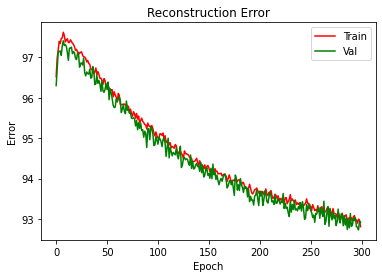

In [63]:
fig = plt.figure()
plt.plot(train_loss, c='r', label="Train")
plt.plot(val_loss, c='g', label="Val")
plt.legend()
plt.title("Reconstruction Error")
plt.xlabel("Epoch")
plt.ylabel("Error")



Sampled images 3....


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


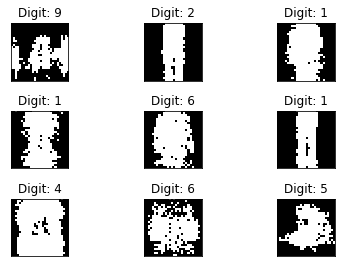

In [64]:
print("\n\nSampled images 3....")
fig2 = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()

  # 1 step sampling
  img = rbm_3.reconstruct_image(test[i].T.reshape((784,1)))

  plt.imshow(img.reshape((28,28)), cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(test_y[i]))
  plt.xticks([])
  plt.yticks([])



Sampled images 4....


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


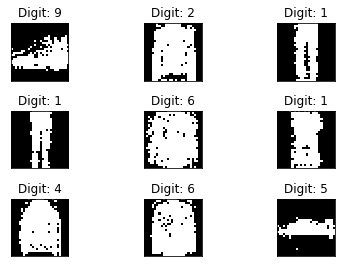

In [65]:
print("\n\nSampled images 4....")
fig2 = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()

  # 1 step sampling
  img = rbm_4.reconstruct_image(test[i].T.reshape((784,1)))

  plt.imshow(img.reshape((28,28)), cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(test_y[i]))
  plt.xticks([])
  plt.yticks([])

In [66]:
err_1 = rbm_1.reconstruction_error(test.T)
err_3 = rbm_3.reconstruction_error(test.T)
err_4 = rbm_4.reconstruction_error(test.T)

print("Reconstruction error using original RBM : ", err_1)
print("Reconstruction error using modified RBM : ", err_3)
print("Reconstruction error using modified RBM : ", err_4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Reconstruction error using original RBM :  73.9085
Reconstruction error using modified RBM :  206.2768
Reconstruction error using modified RBM :  93.2079


# Train stack of RBMs after the individual ones are trained

In [67]:
class RBM_ret_full():
    def __init__(self, num_hidden, num_visible, lr, n, batch_size, epochs, W_prior, b_v_prior, b_h_prior, W_old, b_v_old, b_h_old):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.lr = lr
        self.n = n
        self.batch_size = batch_size
        self.epochs = epochs
        self.W_prior = W_prior
        self.b_v_prior = b_v_prior
        self.b_h_prior = b_h_prior

        self.W = W_old # weights

        self.b_h = b_h_old # bias latent
        self.b_v = b_v_old # bias visible

        self.dW = []
        self.db_h = []
        self.db_v = []

        self.dW_prior = []
        self.db_h_prior = []
        self.db_v_prior = []

    def sigmoid(self, x):  
        #Sigmoid activation 
        #Implemented interms  of tanh for increased stability
        return .5 * (1 + np.tanh(.5 * x))

    
    def bernoulli_array(self, prob_array, dim):
        # Simulating Bernoulli from uniform
        sample = np.zeros(dim)

        # Draw x~Uni[0,1]
        uni_sample = np.random.uniform(0, 1, dim)

        # return 1 if x < p else return 0
        diff = uni_sample - prob_array
        coords = np.argwhere(diff<0)
        sample[[*coords.T]] = 1  

        return sample

    def gibbs_sampling(self, l_0):

        l = l_0.copy()

        for i in range(self.n):


            # (h x l) @ (l x b) + (l x 1) = (l x b)
            p_h_l = self.sigmoid(self.W_prior.T @ l + self.b_v_prior)
            h = self.bernoulli_array(p_h_l, (p_h_l.shape[0], p_h_l.shape[1]))

            # (v x h) @ (h x b) + (v x 1) = (v x b)
            p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
            v = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))

            # (h x v) @ (v x b) + (h x 1) = (h x b)
            p_h_v = self.sigmoid(self.W @ v + self.b_h)
            h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

            # (h x l) @ (l x b) + (l x 1) = (l x b)
            p_l_h = self.sigmoid(self.W_prior @ h + self.b_h_prior)
            l = self.bernoulli_array(p_l_h, (p_l_h.shape[0], p_l_h.shape[1]))

        return v, h, l, p_h_v, p_l_h

    def hidden_to_visible(self, h):

        h = h.T.copy()

        # (v x h) @ (h x b) + (v x 1) = (v x b)
        p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
        v = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))

        return v.T

    def visible_to_hidden(self, v):

        v = v.T.copy()

        # (h x v) @ (v x b) + (h x 1) = (h x b)
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        return h.T

    def gradient_descent(self, v_0, p_h_v_0, v_n, p_h_v_n):

        # Compute the gradients
        # (h x b) @ (b x v) - (h x b) @ (b x v) = (h x v)
        self.dW = (p_h_v_0 @ v_0 - p_h_v_n @ v_n)/self.batch_size
        self.db_h = np.mean(p_h_v_0 - p_h_v_n, axis=1)[:, np.newaxis]
        self.db_v = np.mean(v_0 - v_n, axis=0)[:, np.newaxis]
        
        # Weight update
        self.W   = self.W   + self.lr * self.dW
        self.b_h = self.b_h + self.lr * self.db_h
        self.b_v = self.b_v + self.lr * self.db_v


    def gradient_descent_prior(self, h_0, p_l_h_0, h_n, p_l_h_n):

        # Compute the gradients
        # (l x b) @ (b x h) - (l x b) @ (b x h) = (l x h)
        self.dW_prior = (p_l_h_0 @ h_0 - p_l_h_n @ h_n)/self.batch_size
        self.db_h_prior = np.mean(p_l_h_0 - p_l_h_n, axis=1)[:, np.newaxis]
        self.db_v_prior = np.mean(h_0 - h_n, axis=0)[:, np.newaxis]
        
        # Weight update
        self.W_prior   = self.W_prior   + self.lr * self.dW_prior
        self.b_h_prior = self.b_h_prior + self.lr * self.db_h_prior
        self.b_v_prior = self.b_v_prior + self.lr * self.db_v_prior


    def reconstruction_error(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # For prior RBM
        p_l_h = self.sigmoid(self.W_prior @ h + self.b_h_prior)
        l = self.bernoulli_array(p_l_h, (p_l_h.shape[0], p_l_h.shape[1]))

        p_h_l = self.sigmoid(self.W_prior.T @ l + self.b_v_prior)
        h_cap = self.bernoulli_array(p_h_l, (p_h_l.shape[0], p_h_l.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h_cap + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return np.sum(np.mean((v-v_sampled)**2, axis=1), axis=0)


    def reconstruct_image(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # For prior RBM
        p_l_h = self.sigmoid(self.W_prior @ h + self.b_h_prior)
        l = self.bernoulli_array(p_l_h, (p_l_h.shape[0], p_l_h.shape[1]))

        p_h_l = self.sigmoid(self.W_prior.T @ l + self.b_v_prior)
        h_cap = self.bernoulli_array(p_h_l, (p_h_l.shape[0], p_h_l.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h_cap + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return v_sampled


    def Train(self, train, val):

        num_batches = int(train.shape[0]/self.batch_size)
        train_loss = []
        val_loss = []

        for epoch in range(self.epochs):

            # Shuffling the data
            train = np.random.permutation(train)

            # Splitting data into batches
            batches = np.array_split(train, num_batches)

            for i in range(num_batches):

                # visible units from data
                v_0 = batches[i].T

                # (h x v) @ (v x b) + (h x 1) = (h x b)
                p_h_v_0 = self.sigmoid(self.W @ v_0 + self.b_h)
                h_0 = self.bernoulli_array(p_h_v_0, (p_h_v_0.shape[0], p_h_v_0.shape[1]))

                # For prior RBM
                p_l_h_0 = self.sigmoid(self.W_prior @ h_0 + self.b_h_prior)
                l_0 = self.bernoulli_array(p_l_h_0, (p_l_h_0.shape[0], p_l_h_0.shape[1]))

                # Run the markov chain
                v_n, h_n, l_n, p_h_v_n, p_l_h_n = self.gibbs_sampling(l_0)

                # Compute gradients
                self.gradient_descent(v_0.T, p_h_v_0, v_n.T, p_h_v_n)
                self.gradient_descent_prior(h_0.T, p_l_h_0, h_n.T, p_l_h_n)

            # Compute reconstruction errror
            error_train = self.reconstruction_error(train.T)
            error_val = self.reconstruction_error(val.T)

            print(f"Epoch {epoch+1} ------> Error => Train : {error_train}, Val : {error_val}")
 
            train_loss.append(error_train)
            val_loss.append(error_val)

        return train_loss, val_loss

In [68]:
# RBM config
num_hidden = 256 # number of hidden units
lr = 0.001 # learning rate for gradient descent
n = 1 # number of Gibbs sampling steps
batch_size = 100 # mini batch size for gradient update
epochs = 300 # number of epochs

In [ ]:
rbm_5 = RBM_ret_full(num_hidden, val.shape[1], lr, n, batch_size, epochs, rbm_2.W, rbm_2.b_v, rbm_2.b_h, rbm_1.W, rbm_1.b_v, rbm_1.b_h)
train_loss, val_loss = rbm_4.Train(train, val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1 ------> Error => Train : 92.86860784313726, Val : 92.843
Epoch 2 ------> Error => Train : 92.9355294117647, Val : 93.0261111111111
Epoch 3 ------> Error => Train : 92.91621568627451, Val : 92.92988888888888
Epoch 4 ------> Error => Train : 93.02133333333333, Val : 93.02833333333334
Epoch 5 ------> Error => Train : 93.0098431372549, Val : 92.98366666666666
Epoch 6 ------> Error => Train : 92.97598039215686, Val : 92.80555555555557
Epoch 7 ------> Error => Train : 92.72574509803921, Val : 92.77022222222223
Epoch 8 ------> Error => Train : 92.92915686274509, Val : 92.90144444444445
Epoch 9 ------> Error => Train : 92.94376470588236, Val : 92.88333333333333
Epoch 10 ------> Error => Train : 92.89250980392157, Val : 92.85766666666667
Epoch 11 ------> Error => Train : 92.85739215686274, Val : 92.84155555555556


In [ ]:
fig = plt.figure()
plt.plot(train_loss, c='r', label="Train")
plt.plot(val_loss, c='g', label="Val")
plt.legend()
plt.title("Reconstruction Error")
plt.xlabel("Epoch")
plt.ylabel("Error")

In [ ]:
print("\n\nSampled images 3....")
fig2 = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()

  # 1 step sampling
  img = rbm_3.reconstruct_image(test[i].T.reshape((784,1)))

  plt.imshow(img.reshape((28,28)), cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(test_y[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
print("\n\nSampled images 4....")
fig2 = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()

  # 1 step sampling
  img = rbm_4.reconstruct_image(test[i].T.reshape((784,1)))

  plt.imshow(img.reshape((28,28)), cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(test_y[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
err_1 = rbm_1.reconstruction_error(test.T)
err_3 = rbm_3.reconstruction_error(test.T)
err_4 = rbm_4.reconstruction_error(test.T)
err_5 = rbm_5.reconstruction_error(test.T)

print("Reconstruction error using original RBM : ", err_1)
print("Reconstruction error using modified RBM : ", err_3)
print("Reconstruction error using retrained RBM : ", err_4)
print("Reconstruction error using retrained full RBM : ", err_5)